In [1]:
import os
import itertools
import numpy as np
import tensorflow as tf
import matplotlib as plt
import keras.backend as K
import matplotlib.pyplot as plt
from keras import models, layers, Input
from keras.layers import Input
from keras.metrics import Metric
from IPython.display import clear_output
from keras.callbacks import ReduceLROnPlateau, Callback
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from keras.optimizers import Adam
from keras.regularizers import l2

In [2]:
DATA_type = 'mels_cnn_1'
Model_name = 'cnn_mels_1'
Train_data=np.load(f'../make_stored_data/{DATA_type}/Train_data.npy')
Train_label=np.load(f'../make_stored_data/{DATA_type}/Train_lebel.npy')
Val_data=np.load(f'../make_stored_data/{DATA_type}/Val_data.npy')
Val_label=np.load(f'../make_stored_data/{DATA_type}/Val_lebel.npy')
print(np.shape(Train_data))
print(np.shape(Train_label))
print(np.shape(Val_data))
print(np.shape(Val_label))

(5, 7200, 256, 4, 1)
(5, 7200)
(5, 1800, 256, 4, 1)
(5, 1800)


In [3]:
class F2Score(Metric):
    def __init__(self, name='f2_score', threshold=0.5, **kwargs):
        super(F2Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = K.cast(y_pred > self.threshold, 'float32')
        y_true = K.cast(y_true, 'float32')

        tp = K.sum(y_true * y_pred)
        fp = K.sum((1 - y_true) * y_pred)
        fn = K.sum(y_true * (1 - y_pred))

        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + K.epsilon())
        recall = self.tp / (self.tp + self.fn + K.epsilon())
        return 5 * (precision * recall) / (4 * precision + recall + K.epsilon())

    def reset_state(self):
        self.tp.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)

class MemoryBestWeights(Callback):
    def __init__(self, monitor='val_f2_score', mode='max'):
        super().__init__()
        self.monitor = monitor
        self.mode = mode
        
        if self.mode == 'min':
            self.best = np.Inf
            self.monitor_op = np.less
        else:
            self.best = -np.Inf
            self.monitor_op = np.greater
        
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:return
        if self.monitor_op(current, self.best):
            self.best = current
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)
            print(f"Restored best weights from {self.monitor} = {self.best:.4f}")
        else:print("No improvement was tracked; model weights not restored.")

In [4]:
best_model_f2 = 0
def custom_f2(recall, precision):
    if recall == 0 or precision == 0:
        return 0
    return 5 / ((4 / recall) + (1 / precision))

os.makedirs("grid_search_outputs", exist_ok=True)

batch_sizes = [16]
learning_rates = [0.0001, 0.0005, 0.001]
hidden_units = [32, 64, 128]
dropouts = [0.05, 0.1]
kernel_regs = [0.01, 0.02]

param_combinations = list(itertools.product(batch_sizes, learning_rates, hidden_units, dropouts, kernel_regs))

results = []
best_model = None
best_model_config_id = None
unused_best_model_recall = 0

for i, (batch_size, lr, hidden_size, dropout_rate, kernel_reg) in enumerate(param_combinations):
    fold_recalls = []
    fold_f2_scores = []
    fold_histories = []
    fold_conf_matrices = []

    for fold in range(5):
        print(f"Running config {i+1}/{len(param_combinations)}")
        print("Config:")
        print(f"  Batch Size     : {batch_size}")
        print(f"  Learning Rate  : {lr}")
        print(f"  Hidden Units   : {hidden_size}")
        print(f"  Dropout Rate   : {dropout_rate}")
        print(f"  Kernel Reg L2  : {kernel_reg}")
        print("-" * 40)
        print(f"Fold : {fold+1}")
        X_train, X_val = Train_data[fold], Val_data[fold]
        y_train, y_val = Train_label[fold], Val_label[fold]

        tf.keras.backend.clear_session()

        model = models.Sequential([
            Input(shape=np.shape(Train_data[0][0])),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(kernel_reg)),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Dropout(dropout_rate),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(kernel_reg)),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Dropout(dropout_rate),
            layers.Flatten(),
            layers.Dense(hidden_size, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=[F2Score(name='f2_score')])

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=0)
        memory_best = MemoryBestWeights(monitor='val_f2_score', mode='max')

        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=100,
                            batch_size=batch_size,
                            callbacks=[reduce_lr, memory_best],
                            verbose=1)

        epoch_recalls = []
        epoch_precisions = []
        epoch_f2_scores = []
        for epoch in range(100):
            y_pred = (model.predict(X_val, verbose=0) > 0.3).astype('int32')
            recall = recall_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred)
            f2 = custom_f2(recall, precision)
            epoch_recalls.append(recall)
            epoch_precisions.append(precision)
            epoch_f2_scores.append(f2)

        best_epoch = int(np.argmax(epoch_f2_scores))
        best_f2 = epoch_f2_scores[best_epoch]
        best_recall = epoch_recalls[best_epoch]

        fold_recalls.append(best_recall)
        fold_f2_scores.append(best_f2)
        fold_histories.append(history)
        y_pred = (model.predict(X_val, verbose=0) > 0.3).astype("int32")
        cm = confusion_matrix(y_val, y_pred)
        fold_conf_matrices.append((cm, y_val, y_pred))
        
        clear_output(wait=False)

    best_fold = int(np.argmax(fold_f2_scores))
    avg_f2 = np.mean(fold_f2_scores)
    avg_recall = np.mean(fold_recalls)

    best_history = fold_histories[best_fold]
    best_cm, best_y_val, best_y_pred = fold_conf_matrices[best_fold]

    results.append({
        'config_id': i,
        'batch_size': batch_size,
        'learning_rate': lr,
        'hidden_size': hidden_size,
        'dropout': dropout_rate,
        'kernel_reg': kernel_reg,
        'avg_val_recall': avg_recall,
        'best_recall': fold_recalls[best_fold],
        'avg_val_f2': avg_f2,
        'best_f2': fold_f2_scores[best_fold],
        'history': best_history,
        'confusion_matrix': best_cm
    })

    if avg_f2 > best_model_f2:
        best_model_f2 = avg_f2
        best_model_config_id = i
        best_model = {
            'history': best_history,
            'confusion_matrix': best_cm,
            'model': model
        }

Running config 1/36
Config:
  Batch Size     : 16
  Learning Rate  : 0.0001
  Hidden Units   : 32
  Dropout Rate   : 0.05
  Kernel Reg L2  : 0.01
----------------------------------------
Fold : 1
Epoch 1/100
450/450 [==============================] - 7s 6ms/step - loss: 0.9011 - f2_score: 0.7777 - val_loss: 0.9278 - val_f2_score: 0.3848 - lr: 1.0000e-04
Epoch 2/100
450/450 [==============================] - 2s 5ms/step - loss: 0.7312 - f2_score: 0.8297 - val_loss: 0.7104 - val_f2_score: 0.8687 - lr: 1.0000e-04
Epoch 3/100
450/450 [==============================] - 2s 5ms/step - loss: 0.6641 - f2_score: 0.8422 - val_loss: 0.6889 - val_f2_score: 0.8353 - lr: 1.0000e-04
Epoch 4/100
450/450 [==============================] - 2s 5ms/step - loss: 0.6127 - f2_score: 0.8556 - val_loss: 0.6213 - val_f2_score: 0.7971 - lr: 1.0000e-04
Epoch 5/100
450/450 [==============================] - 2s 5ms/step - loss: 0.5753 - f2_score: 0.8615 - val_loss: 0.5973 - val_f2_score: 0.8539 - lr: 1.0000e-04
Epoc

KeyboardInterrupt: 

Best Model Metric
----------------------------------------
Config ID           : 11
Batch Size          : 16
Learning Rate       : 0.001
Hidden Units        : 128
Dropout Rate        : 0.1
Kernel Reg L2       : 0.02
Avg Recall (5-fold) : 0.9941
Best Fold Recall    : 0.9908
----------------------------------------


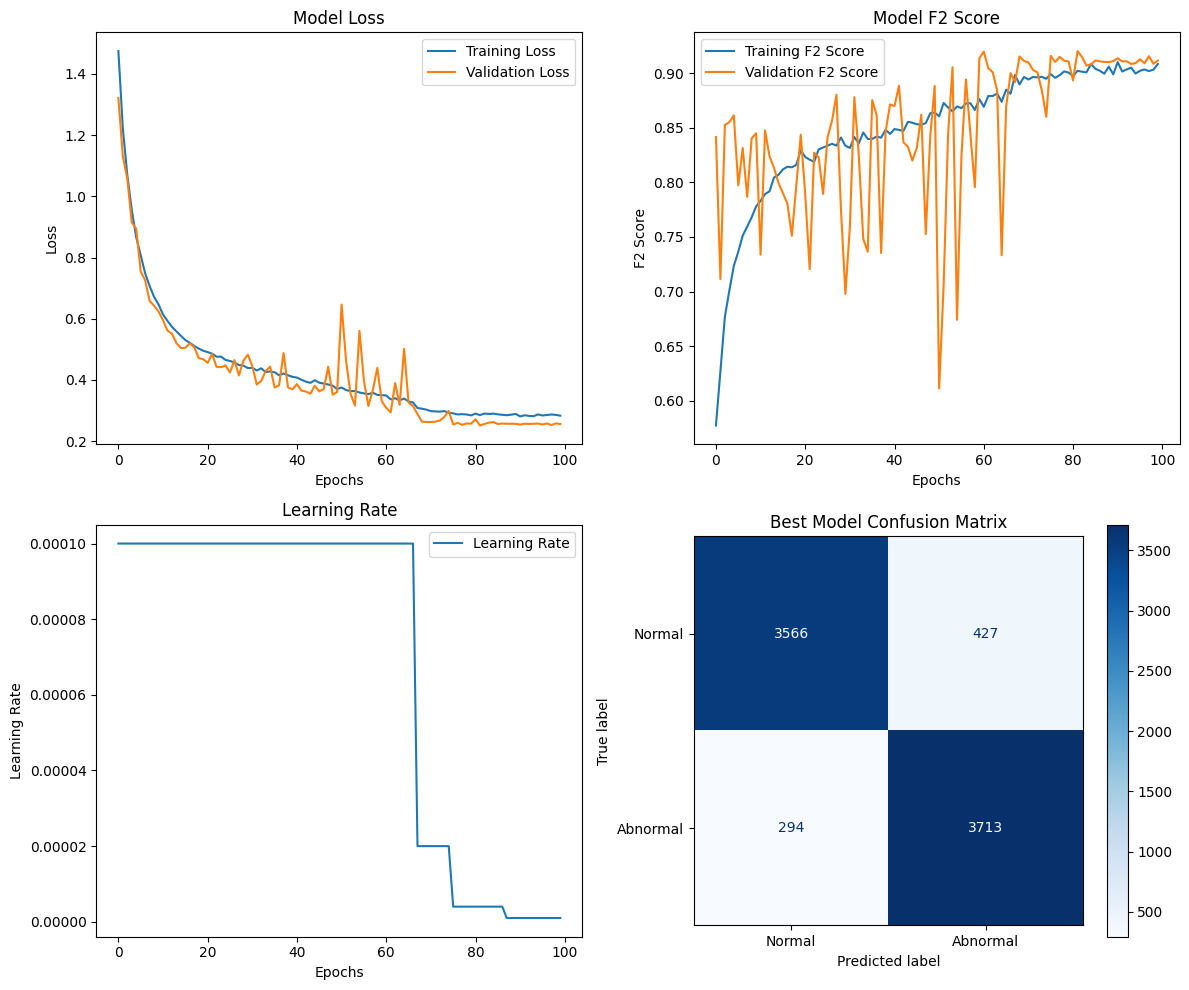

In [ ]:
best_result = results[best_model_config_id]

print("Best Model Metric")
print("-" * 40)
print(f"Config ID           : {best_model_config_id}")
print(f"Batch Size          : {best_result['batch_size']}")
print(f"Learning Rate       : {best_result['learning_rate']}")
print(f"Hidden Units        : {best_result['hidden_size']}")
print(f"Dropout Rate        : {best_result['dropout']}")
print(f"Kernel Reg L2       : {best_result['kernel_reg']}")
print(f"Avg Recall (5-fold) : {best_result['avg_val_recall']:.4f}")
print(f"Best Fold Recall    : {best_result['best_recall']:.4f}")
print(f"Avg F2-score (5-fold) : {best_result['avg_val_f2']:.4f}")
print(f"Best Fold F2-score  : {best_result['best_f2']:.4f}")
print("-" * 40)

best_history = best_model['history']
best_cm = best_model['confusion_matrix']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(best_history.history['loss'], label='Training Loss')
if 'val_loss' in best_history.history:
    axes[0, 0].plot(best_history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

if 'f2_score' in best_history.history:
    axes[0, 1].plot(best_history.history['f2_score'], label='Training F2 Score')
if 'val_f2_score' in best_history.history:
    axes[0, 1].plot(best_history.history['val_f2_score'], label='Validation F2 Score')
axes[0, 1].set_title('Model F2 Score')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('F2 Score')
axes[0, 1].legend()

if 'lr' in best_history.history:
    axes[1, 0].plot(best_history.history['lr'], label='Learning Rate')
elif 'learning_rate' in best_history.history:
    axes[1, 0].plot(best_history.history['learning_rate'], label='Learning Rate')
axes[1, 0].set_title('Learning Rate')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].legend()

disp = ConfusionMatrixDisplay(confusion_matrix=best_cm, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, ax=axes[1, 1])
axes[1, 1].set_title("Best Model Confusion Matrix")

plt.tight_layout()
plt.show()

In [ ]:
best_model['model'].save(f'../new_model/{Model_name}.h5')